In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
from matplotlib_venn import venn2, venn3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy
import itertools
from sklearn.preprocessing import MinMaxScaler, Imputer, LabelEncoder
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE

['POS_CASH_balance.csv', 'bureau_balance.csv', 'application_train.csv', 'previous_application.csv', 'installments_payments.csv', 'credit_card_balance.csv', 'sample_submission.csv', 'application_test.csv', 'bureau.csv']


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('fivethirtyeight')

In [3]:
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
table_names = ['application_train', 'bureau', 'bureau_balance', 'POS_CASH_balance', 
               'credit_card_balance', 'previous_application', 'application_test', 'installments_payments']

In [6]:
tables = [reduce_mem_usage(pd.read_csv(f'../input/{fname}.csv', low_memory=False)) for fname in table_names]

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 128.16 MB
Decreased by 55.2%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 119.49 MB
Decreased by 46.3%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 276.60 MB
Decreased by 54.7%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 318.63 MB
Decreased by 52.7%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 324.94 MB
Decreased by 31.1%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 20.27 MB
Decreased by 55.0%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 389.25 MB
Decreased by 53.1%


In [7]:
application_train, bureau, bureau_balance, POS_CASH_balance, credit_card_balance, previous_application, application_test, installments_payments = tables

In [8]:
train_cols_with_na = application_train.columns[application_train.isna().any()].tolist()
test_cols_with_na = application_test.columns[application_test.isna().any()].tolist()

In [9]:
corr_dict = {}

In [10]:
for col in train_cols_with_na:
    if application_train[col].dtype != 'object':
        corr_dict[col] = abs(application_train[col].corr(application_train['TARGET']))
    else:
        corr_dict[col] = np.nan

In [11]:
corr_df = pd.Series(corr_dict, name='corr_w_TARGET')
corr_df.index.name = 'column_name'

In [12]:
corr_df = corr_df.reset_index()
corr_df.head()

,column_name,corr_w_TARGET
0,AMT_ANNUITY,0.012817
1,AMT_GOODS_PRICE,0.039645
2,AMT_REQ_CREDIT_BUREAU_DAY,0.002704
3,AMT_REQ_CREDIT_BUREAU_HOUR,0.000930
4,AMT_REQ_CREDIT_BUREAU_MON,0.012462


In [13]:
train_missing_values = pd.DataFrame(columns=['column_name','percentage_missing'])
test_missing_values = pd.DataFrame(columns=['column_name','percentage_missing'])

In [14]:
temp_test = (application_test[test_cols_with_na].isna().sum()/application_test.shape[0]).sort_values(ascending=False)
test_missing_values['column_name'] = temp_test.index
test_missing_values['percentage_missing'] = temp_test.values
del temp_test
test_missing_values.head()

,column_name,percentage_missing
0,COMMONAREA_MODE,0.687161
1,COMMONAREA_AVG,0.687161
2,COMMONAREA_MEDI,0.687161
3,NONLIVINGAPARTMENTS_MEDI,0.684125
4,NONLIVINGAPARTMENTS_AVG,0.684125


In [15]:
temp_train = (application_train[train_cols_with_na].isna().sum()/application_train.shape[0]).sort_values(ascending=False)
train_missing_values['column_name'] = temp_train.index
train_missing_values['percentage_missing'] = temp_train.values
del temp_train
train_missing_values.head()

,column_name,percentage_missing
0,COMMONAREA_MEDI,0.698723
1,COMMONAREA_AVG,0.698723
2,COMMONAREA_MODE,0.698723
3,NONLIVINGAPARTMENTS_AVG,0.694330
4,NONLIVINGAPARTMENTS_MODE,0.694330


In [16]:
gc.collect()

28

In [17]:
set(train_missing_values['column_name'].unique()) - set(test_missing_values['column_name'].unique())

{'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'}

In [18]:
train_missing_values[train_missing_values['column_name'].isin(['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'])]

,column_name,percentage_missing
63,AMT_GOODS_PRICE,0.000904
65,CNT_FAM_MEMBERS,0.000007
66,DAYS_LAST_PHONE_CHANGE,0.000003


In [19]:
corr_df[corr_df['column_name'].isin(['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'])]

,column_name,corr_w_TARGET
1,AMT_GOODS_PRICE,0.039645
14,CNT_FAM_MEMBERS,0.009308
18,DAYS_LAST_PHONE_CHANGE,0.055218


In [20]:
train_missing_values = train_missing_values.drop(train_missing_values.index[[63,65,66]])
corr_df = corr_df.drop(corr_df.index[[1,14,18]])
print(set(train_missing_values['column_name'].unique()) - set(test_missing_values['column_name'].unique()))
print(set(corr_df['column_name'].unique()) - set(test_missing_values['column_name'].unique()))

set()
set()


In [21]:
missing_data_dist = train_missing_values.merge(test_missing_values,on='column_name',suffixes=('_train','_test'))
missing_data_dist = missing_data_dist.merge(corr_df,on='column_name')
missing_data_dist.head()

,column_name,percentage_missing_train,percentage_missing_test,corr_w_TARGET
0,COMMONAREA_MEDI,0.698723,0.687161,0.018573
1,COMMONAREA_AVG,0.698723,0.687161,0.018550
2,COMMONAREA_MODE,0.698723,0.687161,0.016340
3,NONLIVINGAPARTMENTS_AVG,0.694330,0.684125,0.003176
4,NONLIVINGAPARTMENTS_MODE,0.694330,0.684125,0.001557


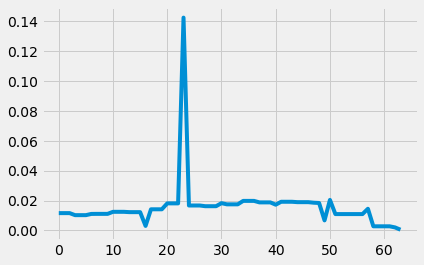

In [22]:
missing_data_dist['abs_diff'] = abs(missing_data_dist['percentage_missing_train']-missing_data_dist['percentage_missing_test'])
missing_data_dist['abs_diff'].plot()

In [23]:
missing_data_dist.sort_values(by=['abs_diff'],ascending=False).head()

,column_name,percentage_missing_train,percentage_missing_test,corr_w_TARGET,abs_diff
23,EXT_SOURCE_1,0.563811,0.421221,0.155317,0.142590
50,EXT_SOURCE_3,0.198253,0.177827,0.178919,0.020426
36,ENTRANCES_MEDI,0.503488,0.483731,0.019025,0.019756
34,ENTRANCES_MODE,0.503488,0.483731,0.017387,0.019756
35,ENTRANCES_AVG,0.503488,0.483731,0.019172,0.019756


In [24]:
missing_data_dist.sort_values(by=['corr_w_TARGET'],ascending=False).head(10)

,column_name,percentage_missing_train,percentage_missing_test,corr_w_TARGET,abs_diff
50,EXT_SOURCE_3,0.198253,0.177827,0.178919,0.020426
62,EXT_SOURCE_2,0.002146,0.000164,0.160472,0.001982
23,EXT_SOURCE_1,0.563811,0.421221,0.155317,0.142590
43,FLOORSMAX_AVG,0.497608,0.478438,0.044003,0.019170
42,FLOORSMAX_MEDI,0.497608,0.478438,0.043768,0.019170
41,FLOORSMAX_MODE,0.497608,0.478438,0.043226,0.019170
16,OWN_CAR_AGE,0.659908,0.662892,0.037612,0.002984
29,ELEVATORS_AVG,0.532960,0.516761,0.034199,0.016199
28,ELEVATORS_MEDI,0.532960,0.516761,0.033863,0.016199
10,FLOORSMIN_AVG,0.678486,0.666051,0.033614,0.012435


In [25]:
temp_train = application_train.copy()

In [26]:
temp_train['EXT_SOURCE_1_bin'] = pd.cut(temp_train['EXT_SOURCE_1'], 10)
temp_train['EXT_SOURCE_1_bin'] = temp_train['EXT_SOURCE_1_bin'].cat.add_categories(['Missing'])
temp_train['EXT_SOURCE_1_bin'].fillna('Missing', inplace=True)

temp_train['EXT_SOURCE_2_bin'] = pd.cut(temp_train['EXT_SOURCE_2'], 10)
temp_train['EXT_SOURCE_2_bin'] = temp_train['EXT_SOURCE_2_bin'].cat.add_categories(['Missing'])
temp_train['EXT_SOURCE_2_bin'].fillna('Missing', inplace=True)

temp_train['EXT_SOURCE_3_bin'] = pd.cut(temp_train['EXT_SOURCE_3'], 10)
temp_train['EXT_SOURCE_3_bin'] = temp_train['EXT_SOURCE_3_bin'].cat.add_categories(['Missing'])
temp_train['EXT_SOURCE_3_bin'].fillna('Missing', inplace=True)

EXT_SOURCE_1_bin
(0.0136, 0.109]    0.250382
(0.109, 0.204]     0.161031
(0.204, 0.299]     0.116941
(0.299, 0.394]     0.091484
(0.394, 0.489]     0.072018
(0.489, 0.583]     0.060000
(0.583, 0.678]     0.049746
(0.678, 0.773]     0.037214
(0.773, 0.868]     0.028621
(0.868, 0.963]     0.019782
Missing            0.085195
Name: TARGET, dtype: float64
AxesSubplot(0.08,0.07;0.87x0.81)
EXT_SOURCE_2_bin
(-0.000855, 0.0855]    0.241478
(0.0855, 0.171]        0.169505
(0.171, 0.256]         0.136587
(0.256, 0.342]         0.114975
(0.342, 0.427]         0.101108
(0.427, 0.513]         0.084331
(0.513, 0.598]         0.071306
(0.598, 0.684]         0.054739
(0.684, 0.769]         0.037161
(0.769, 0.855]         0.021247
Missing                0.078788
Name: TARGET, dtype: float64
AxesSubplot(0.08,0.07;0.87x0.81)
EXT_SOURCE_3_bin
(-0.000368, 0.0901]    0.269153
(0.0901, 0.18]         0.201384
(0.18, 0.269]          0.152535
(0.269, 0.359]         0.112888
(0.359, 0.448]         0.087875
(0.44

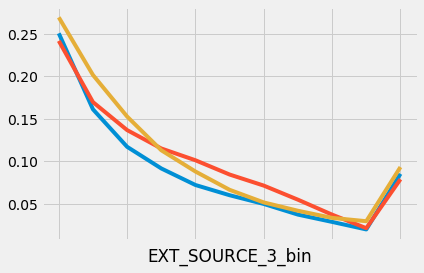

In [27]:
print(temp_train.groupby(by='EXT_SOURCE_1_bin')['TARGET'].mean().sort_index())
print(temp_train.groupby(by='EXT_SOURCE_1_bin')['TARGET'].mean().sort_index().plot())

print(temp_train.groupby(by='EXT_SOURCE_2_bin')['TARGET'].mean().sort_index())
print(temp_train.groupby(by='EXT_SOURCE_2_bin')['TARGET'].mean().sort_index().plot())

print(temp_train.groupby(by='EXT_SOURCE_3_bin')['TARGET'].mean().sort_index())
print(temp_train.groupby(by='EXT_SOURCE_3_bin')['TARGET'].mean().sort_index().plot())

In [28]:
del temp_train

# Downsampling 0s

In [29]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [30]:
application_train_1s = application_train[application_train['TARGET'] == 1]

In [31]:
application_train_0s = application_train[application_train['TARGET'] == 0].iloc[np.random.permutation(len(application_train[application_train['TARGET'] == 0]))[:len(application_train[application_train['TARGET'] == 1])]]

In [32]:
application_train_1s['TARGET'].value_counts()

1    24825
Name: TARGET, dtype: int64

In [33]:
application_train_0s['TARGET'].value_counts()

0    24825
Name: TARGET, dtype: int64

In [34]:
df = pd.concat([application_train_0s, application_train_1s])
df = df.iloc[np.random.permutation(len(df))]

In [35]:
df['TARGET'].value_counts()

1    24825
0    24825
Name: TARGET, dtype: int64

In [36]:
X = application_train.copy()
X = pd.get_dummies(X)
X.fillna(0, inplace=True)

In [37]:
x_resampled, y_resampled = SMOTE().fit_sample(X.drop('TARGET',axis=1),X['TARGET'])

In [38]:
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

{0: 282686, 1: 282686}

In [39]:
X_resampled = pd.DataFrame(data=x_resampled, columns=X.drop('TARGET',axis=1).columns)

In [40]:
X_resampled['TARGET'] = y_resampled

In [41]:
X_resampled.shape

(565372, 246)

In [42]:
X.drop('TARGET',axis=1).columns

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=245)

In [43]:
application_train[application_train['TARGET'] == 0]['SK_ID_CURR'].iloc[np.random.permutation(len(application_train[application_train['TARGET'] == 0]))[:len(application_train[application_train['TARGET'] == 1])]].sort_index().head()

3     100006
7     100010
17    100021
35    100041
41    100048
Name: SK_ID_CURR, dtype: int32

In [44]:
temp = application_test[['SK_ID_CURR']].copy()
temp['Target'] = 0
temp.head()

,SK_ID_CURR,Target
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
